### RQ1: Was there any significant effect of the war on Ireland's energy consumption?

In [306]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [307]:
# Load the Excel file
file_path = r"C:\Users\grace\Desktop\Dissertation\data\seas\Final-Energy-Consumption.xlsx"
excel_data = pd.ExcelFile(file_path)

# Load the first sheet into a DataFrame
df_first_sheet = excel_data.parse(sheet_name=excel_data.sheet_names[0])

# Extract the last row of the DataFrame
last_row = df_first_sheet.tail(1)

# Convert all column names to strings
last_row.columns = last_row.columns.map(str)

# Print the columns to understand their structure
print("Columns in the last row:", last_row.columns)

Columns in the last row: Index(['TFC', 'Unnamed: 1', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype='object')


In [308]:
# Filter the columns to include only the years from 2010 to 2022
years_of_interest = [str(year) for year in range(2010, 2022 + 1)]
filtered_data = last_row[[col for col in last_row.columns if col.strip() in years_of_interest]]

# Create a new DataFrame with years as a column
new_df = pd.DataFrame({
    'Year': filtered_data.columns,
    'Total Energy Consumption': filtered_data.values[0]
})

# Display the new DataFrame
new_df.head()

,Year,Total Energy Consumption
0,2010,11884.374798
1,2011,11084.673482
2,2012,10727.657151
3,2013,10908.688609
4,2014,10873.258243


In [309]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      13 non-null     object 
 1   Total Energy Consumption  13 non-null     float64
dtypes: float64(1), object(1)
memory usage: 340.0+ bytes


In [322]:
new_df.describe()

,Total Energy Consumption
count,13.000000
mean,11558.999518
std,576.368660
min,10727.657151
25%,11084.673482
50%,11513.886376
75%,11889.276665
max,12437.366815


In [310]:
# Convert the 'Year' column to datetime
new_df['Year'] = pd.to_datetime(new_df['Year'])

In [324]:
new_df.isnull().sum()

Total Energy Consumption    0
dtype: int64

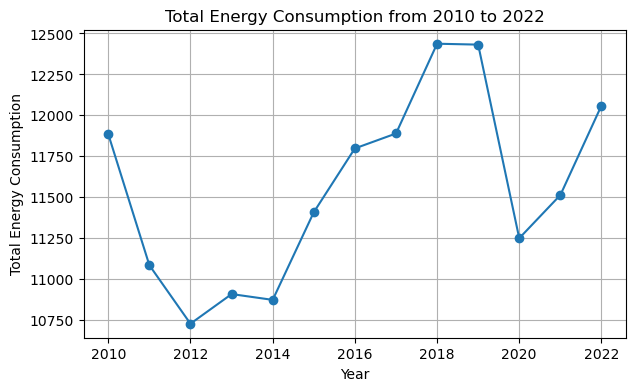

In [311]:
# Plot the data
plt.figure(figsize=(7, 4))
plt.plot(new_df['Year'], new_df['Total Energy Consumption'], marker='o')
plt.title('Total Energy Consumption from 2010 to 2022')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption')
plt.grid(True)
plt.show()

### ARIMA Model

In [312]:
# Extract the 'Total Energy Consumption' column
y = new_df['Total Energy Consumption']

In [313]:
# Step 2: Stationarity Check (ADF Test)
result_adf = sm.tsa.adfuller(new_df['Total Energy Consumption'])
print("ADF Test Results:")
print(f"ADF Statistic: {result_adf[0]:.4f}")
print(f"P-value: {result_adf[1]:.4f}")
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"{key}: {value:.4f}")
    
    
# If p-value is less than a significance level (e.g., 0.05), reject the null hypothesis (series is stationary)
if result_adf[1] < 0.05:
    print("Time series is stationary (reject null hypothesis).")
else:
    print("Time series is not stationary (fail to reject null hypothesis).")

ADF Test Results:
ADF Statistic: -3.9725
P-value: 0.0016
Critical Values:
1%: -4.4731
5%: -3.2899
10%: -2.7724
Time series is stationary (reject null hypothesis).


In [314]:
# Train-test split
train, test = train_test_split(y, train_size=0.8)

In [315]:
# Perform grid search to find the best parameters for a non-seasonal ARIMA model
model = pm.auto_arima(train, 
                      seasonal=False,  # Turn off seasonality due to limited data
                      stepwise=True, 
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True, 
                      max_p=3, max_q=3, 
                      start_p=0, start_q=0,
                      information_criterion='aic')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=217.485, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=160.415, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=154.705, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=154.024, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=157.779, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=155.817, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=156.256, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.513 seconds


In [316]:
# Set 'Year' as the index (required for time series analysis)
new_df.set_index('Year', inplace=True)

In [317]:
# Step 3: Fit SARIMA model
order = (2, 0, 0)  # Example order (p, d, q)
seasonal_order = (1, 0, 0, 12)  # Example seasonal order (P, D, Q, s)

model = sm.tsa.statespace.SARIMAX(new_df['Total Energy Consumption'],
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
results = model.fit()

C:\Users\grace\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\grace\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\grace\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\grace\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [318]:
# Step 4: Get forecasts (optional)
forecast_steps = 12  # Example: forecast next 12 months
forecastsarima = results.get_forecast(steps=forecast_steps)

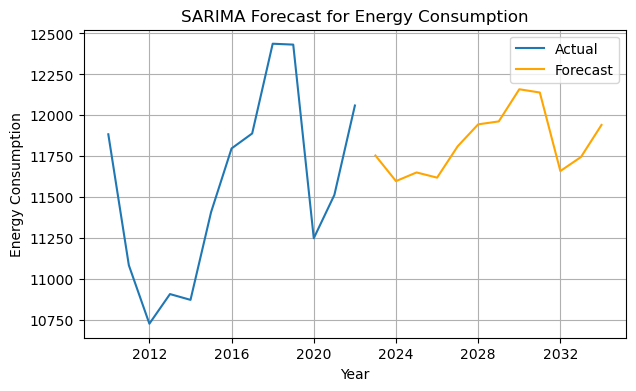

In [319]:
# Step 5: Plot actual vs. forecast (optional)
plt.figure(figsize=(7, 4))
plt.plot(new_df.index, new_df['Total Energy Consumption'], label='Actual')
plt.plot(forecastsarima.predicted_mean.index, forecastsarima.predicted_mean, label='Forecast', color='orange')
plt.xlabel('Year')
plt.ylabel('Energy Consumption')
plt.title('SARIMA Forecast for Energy Consumption')
plt.grid(True)
plt.legend()
plt.show()

In [320]:
# Step 6: Print summary of the model
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:           Total Energy Consumption   No. Observations:                   13
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -102.980
Date:                            Wed, 12 Jun 2024   AIC                            213.961
Time:                                    13:55:35   BIC                            216.221
Sample:                                01-01-2010   HQIC                           213.496
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0488      0.540      1.944      0.052      -0.009       2.106
ar.L2         -0.0511      0.531   

In [321]:
# Step 6: Calculate RMSE
forecast_values = forecastsarima.predicted_mean
# For the sake of this example, I'll generate random actual values
actual_values = np.random.normal(loc=forecast_values, scale=5)  # Example random actual values
mse = mean_squared_error(actual_values, forecast_values)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 3.3584316207802574
